In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# TODO: Check with lecture if we can use cv2 or PIL for image checking
import os
from PIL import Image
import cv2
from collections import Counter
from skimage import io, color, exposure
import random
from collections import defaultdict
import matplotlib.gridspec as gridspec

# Seed the random for reproduce purpose
random.seed(42)


## Exploratory Data Analysis
This section aims to perform the exploratory data analysis (EDA) on the dataset. The EDA consists of two main parts, including:

### Basic information

In [6]:
# Load the data set
dataset_path = './data/data_labels_mainData.csv'
data = pd.read_csv(dataset_path)

In [7]:
print("Dataset Overview:")
print(f"Dataset shape: {data.shape}")
print("\nFirst few rows:")
print(data.head())

Dataset Overview:
Dataset shape: (9896, 6)

First few rows:
   InstanceID  patientID  ImageName cellTypeName  cellType  isCancerous
0       22405          1  22405.png   fibroblast         0            0
1       22406          1  22406.png   fibroblast         0            0
2       22407          1  22407.png   fibroblast         0            0
3       22408          1  22408.png   fibroblast         0            0
4       22409          1  22409.png   fibroblast         0            0


In [8]:
# 2. Basic Data Information
print("\n--- Data Information ---")
print(data.info())


--- Data Information ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9896 entries, 0 to 9895
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   InstanceID    9896 non-null   int64 
 1   patientID     9896 non-null   int64 
 2   ImageName     9896 non-null   object
 3   cellTypeName  9896 non-null   object
 4   cellType      9896 non-null   int64 
 5   isCancerous   9896 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 464.0+ KB
None


In [9]:
print("\n--- Missing Values ---")
print(data.isnull().sum())


--- Missing Values ---
InstanceID      0
patientID       0
ImageName       0
cellTypeName    0
cellType        0
isCancerous     0
dtype: int64


The data_labels_mainData.csv dataset has 9896 rows and 6 columns, in which there are two ID columns including the InstanceID and patientID. The two columns **cellType** and **isCancerous** are two target variables. The cellTypeName is the text version of the **cellType** column. For the independent columns, ImageName the path to the image located under **patches_images** folder. The dataset does not have any missing value.

### Explore the categorical variables

#### isCancerous variable

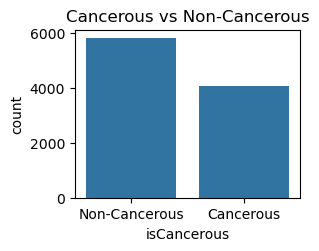

In [10]:
# 4.2 Cancerous Distribution
plt.subplot(2, 2, 2)
sns.countplot(x='isCancerous', data=data)
plt.title('Cancerous vs Non-Cancerous')
plt.xticks([0, 1], ['Non-Cancerous', 'Cancerous'])
plt.show()

#### Cell Type

In [11]:
cell_type_counts = data[['cellType', 'cellTypeName']].value_counts().reset_index()
cell_type_counts.columns = ['cellType', 'cellTypeName', 'Count']
cell_type_counts

,cellType,cellTypeName,Count
0,2,epithelial,4079
1,1,inflammatory,2543
2,0,fibroblast,1888
3,3,others,1386


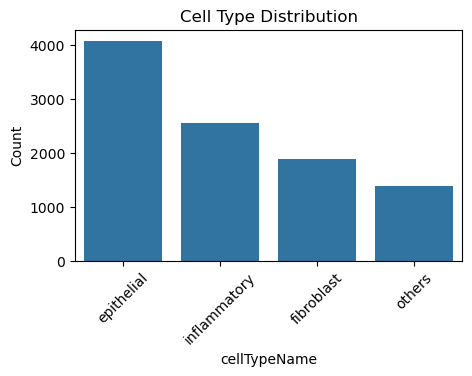

In [12]:
plt.figure(figsize=(5, 3))
sns.barplot(cell_type_counts, x="cellTypeName", y="Count")
plt.title('Cell Type Distribution')
plt.xticks(rotation=45)
plt.show()

###### For the cell type varible, the cell type is already encoded, which is shown in the following table. 
2	epithelial	4079
1	1	inflammatory	2543
2	0	fibroblast	1888
3	3	others

| Cell type name | Encoded value |
| - | - |
| fibroblast | 0 |
| inflammatory | 1 |
| epithelial | 2 |
| others | 3 |


Also, the distribution of the cell type shows that the classes are imbalanced. For example, the **epithelial** class has 4079 instances, which is nearly twice (~2.16) as many as the fibroblast class.

### Patient distribution

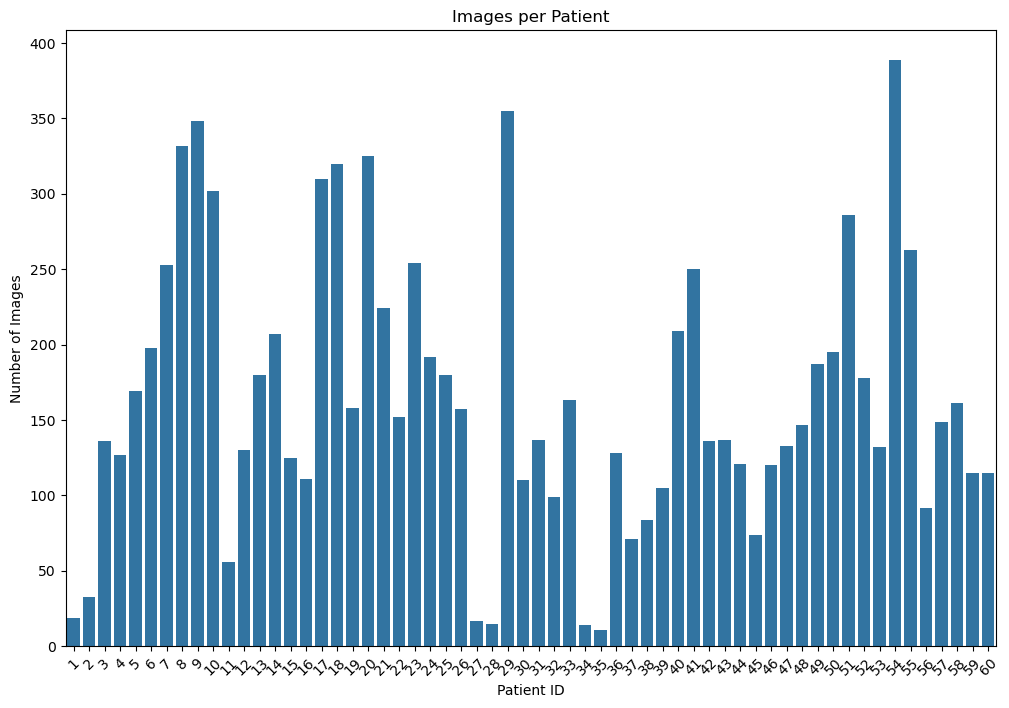

In [13]:
patient_counts = data['patientID'].value_counts()
plt.figure(figsize=(12, 8))

sns.barplot(x=patient_counts.index, y=patient_counts.values)

plt.title('Images per Patient')
plt.xlabel('Patient ID')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

In [14]:
sorted_counts = patient_counts.sort_values(ascending=False)
sorted_counts.head(10)

patientID
54    389
29    355
9     348
8     332
20    325
18    320
17    310
10    302
51    286
55    263
Name: count, dtype: int64

In [15]:
sorted_counts.tail(10)

patientID
38    84
45    74
37    71
11    56
2     33
1     19
27    17
28    15
34    14
35    11
Name: count, dtype: int64

From the given chart, the provided images for each patient is not distributed evenly. For example, the patient **54** has 389 instances, wherease, there are only **11** instances for patient 35.

### Cell type and Cancerous Status

This section aims to examine the relationsip between two categorical varibales (isCanerous and cellType) to answer the question in which cell type is detected, the patient will have cancer?

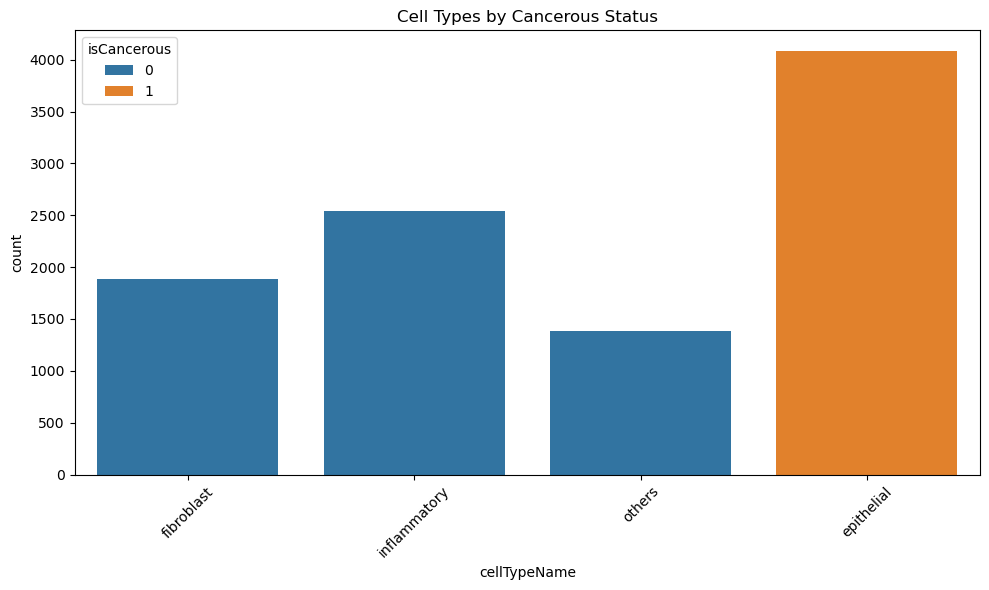

In [16]:
plt.figure(figsize=(10, 6))
sns.countplot(x='cellTypeName', hue='isCancerous', data=data)
plt.title('Cell Types by Cancerous Status')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

From the given chart, it is noticeable that when the epithelial cell type is detected, the patient is diagonised as having cancer.

### Image analysis

The image is analyzed with three main aspects, including: **aspect ratio**, **size**, **color chanel**

**Image sizes**

Text(0.5, 1.0, 'Distribution of Image Dimensions')

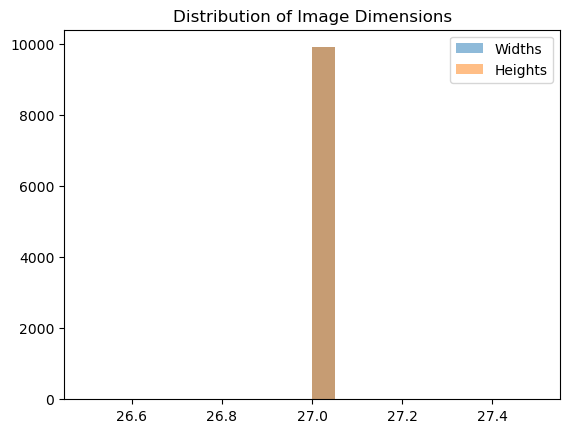

In [17]:
# TODO: add the code for the image analysis here. Check for the size, noise and resolution
from collections import Counter
sizes = [Image.open(f"./data/patch_images/{img}").size for img in data['ImageName'].values]
# sizes = [Image.open(f"dataset/class1/{img}").size for img in images]
widths, heights = zip(*sizes)
plt.hist(widths, bins=20, alpha=0.5, label='Widths')
plt.hist(heights, bins=20, alpha=0.5, label='Heights')
plt.legend()
plt.title("Distribution of Image Dimensions")

In [18]:

# Set style for plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

def analyze_images_by_cell_type(data, image_dir, cell_type_name):
    
    # Check if directory exists
    if not os.path.exists(image_dir):
        print(f"Image directory {image_dir} not found. Skipping analysis.")
        return
    
    # Create dictionaries to store sample images and their analyses
    sample_images = {}
    image_analyses = defaultdict(dict)
    
    # Get all images of this cell type
    cell_type_images = data[data['cellTypeName'] == cell_type_name]['ImageName'].tolist()
    
    if not cell_type_images:
        print(f"No images found for cell type {cell_type} ({cell_type_name})")
        return    
    # Randomly select one image
    selected_img_name = random.choice(cell_type_images)
    image_path = os.path.join(image_dir, selected_img_name)
    
    try:
        # Try to read the image
        img = cv2.imread(image_path)
        
        if img is None:
            print(f"Could not read image: {image_path}")
            return
            
        # Store the image and its details
        sample_images[cell_type_name] = {
            'name': selected_img_name,
            'image': img,
            'cell_type_name': cell_type_name
        }
        
        # Perform analysis
        image_analyses[cell_type_name] = analyze_single_image(img, selected_img_name, cell_type_name)
        
    except Exception as e:
        print(f"Error processing image {image_path}: {str(e)}")
    
    # Create visualizations
    if sample_images:
        # Create a comprehensive figure with subplots
        visualize_image_analyses(sample_images, image_analyses)
    else:
        print("No images could be processed for analysis.")

def analyze_single_image(img, img_name, cell_type_name):
    # Convert BGR to RGB for analysis
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Convert to HSV and LAB color spaces for additional analysis
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    
    # Convert to grayscale
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Basic image properties
    height, width, channels = img.shape
    
    # Intensity analysis
    channel_names = ['Red', 'Green', 'Blue']
    channel_stats = {}
    
    for i, channel_name in enumerate(channel_names):
        channel = img_rgb[:,:,i]
        channel_stats[channel_name] = {
            'mean': np.mean(channel),
            'std': np.std(channel),
            'min': np.min(channel),
            'max': np.max(channel),
            'median': np.median(channel),
            'histogram': np.histogram(channel, bins=256, range=(0,256))[0]
        }
    
    # Grayscale intensity
    gray_stats = {
        'mean': np.mean(img_gray),
        'std': np.std(img_gray),
        'min': np.min(img_gray),
        'max': np.max(img_gray),
        'median': np.median(img_gray),
        'histogram': np.histogram(img_gray, bins=256, range=(0,256))[0]
    }
    
    # HSV analysis
    hsv_names = ['Hue', 'Saturation', 'Value']
    hsv_stats = {}
    
    for i, hsv_name in enumerate(hsv_names):
        channel = img_hsv[:,:,i]
        hsv_stats[hsv_name] = {
            'mean': np.mean(channel),
            'std': np.std(channel),
            'min': np.min(channel),
            'max': np.max(channel),
            'median': np.median(channel),
            'histogram': np.histogram(channel, bins=256, range=(0,256))[0]
        }
    
    # Calculate texture features using GLCM or other methods if needed
    # (Code for texture analysis would go here)
    
    # Calculate basic edge statistics
    edges = cv2.Canny(img_gray, 100, 200)
    edge_percentage = np.sum(edges > 0) / (height * width) * 100
    
    return {
        'filename': img_name,
        'cell_type': cell_type_name,
        'dimensions': {'height': height, 'width': width, 'channels': channels},
        'size_bytes': img.nbytes,
        'rgb_stats': channel_stats,
        'gray_stats': gray_stats,
        'hsv_stats': hsv_stats,
        'edge_percentage': edge_percentage
    }

def visualize_image_analyses(sample_images, image_analyses):
    n_cell_types = len(sample_images)
    
    for cell_type, img_data in sample_images.items():
        analysis = image_analyses[cell_type]
        img = img_data['image']
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        cell_type_name = img_data['cell_type_name']
        img_name = img_data['name']
        
        # Create a large figure with multiple subplots
        fig = plt.figure(figsize=(20, 16))
        gs = gridspec.GridSpec(4, 4)
        
        # Title with image and cell information
        plt.suptitle(f"Analysis of {img_name} - {cell_type_name} (Cell Type {cell_type})", 
                     fontsize=16, y=0.98)
        
        # 1. Original Image
        ax1 = plt.subplot(gs[0, 0])
        ax1.imshow(img_rgb)
        ax1.set_title("Original Image")
        ax1.axis('off')
        ax1.text(0.05, 0.95, f"Size: {analysis['dimensions']['width']}×{analysis['dimensions']['height']}", 
                transform=ax1.transAxes, fontsize=10, va='top')
        
        # 2. RGB Channels
        # Red Channel
        ax2 = plt.subplot(gs[0, 1])
        ax2.imshow(img_rgb[:,:,0], cmap='Reds')
        ax2.set_title("Red Channel")
        ax2.axis('off')
        
        # Green Channel
        ax3 = plt.subplot(gs[0, 2])
        ax3.imshow(img_rgb[:,:,1], cmap='Greens')
        ax3.set_title("Green Channel")
        ax3.axis('off')
        
        # Blue Channel
        ax4 = plt.subplot(gs[0, 3])
        ax4.imshow(img_rgb[:,:,2], cmap='Blues')
        ax4.set_title("Blue Channel")
        ax4.axis('off')
        
        # 3. Grayscale Image
        ax5 = plt.subplot(gs[1, 0])
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ax5.imshow(img_gray, cmap='gray')
        ax5.set_title("Grayscale")
        ax5.axis('off')
        
        # 4. Edge Detection
        ax6 = plt.subplot(gs[1, 1])
        edges = cv2.Canny(img_gray, 100, 200)
        ax6.imshow(edges, cmap='gray')
        ax6.set_title(f"Edges ({analysis['edge_percentage']:.2f}% pixels)")
        ax6.axis('off')
        
        # 5. HSV Representation
        ax7 = plt.subplot(gs[1, 2])
        img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        ax7.imshow(cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB))
        ax7.set_title("HSV Representation")
        ax7.axis('off')
        
        # 6. Histogram Equalized
        ax8 = plt.subplot(gs[1, 3])
        img_eq = exposure.equalize_hist(img_gray)
        ax8.imshow(img_eq, cmap='gray')
        ax8.set_title("Histogram Equalized")
        ax8.axis('off')
        
        # 7. RGB Histograms
        ax9 = plt.subplot(gs[2, :2])
        colors = ['r', 'g', 'b']
        channel_names = ['Red', 'Green', 'Blue']
        
        for i, (c, name) in enumerate(zip(colors, channel_names)):
            hist = analysis['rgb_stats'][name]['histogram']
            ax9.plot(hist, color=c, label=f"{name} (μ={analysis['rgb_stats'][name]['mean']:.1f})")
        
        ax9.set_title("RGB Histograms")
        ax9.set_xlabel("Pixel Value")
        ax9.set_ylabel("Frequency")
        ax9.legend()
        ax9.grid(True, alpha=0.3)
        
        # 8. Grayscale Histogram
        ax10 = plt.subplot(gs[2, 2:])
        hist = analysis['gray_stats']['histogram']
        ax10.plot(hist, color='black')
        ax10.set_title(f"Grayscale Histogram (μ={analysis['gray_stats']['mean']:.1f}, σ={analysis['gray_stats']['std']:.1f})")
        ax10.set_xlabel("Pixel Value")
        ax10.set_ylabel("Frequency")
        ax10.grid(True, alpha=0.3)
        
        # 9. HSV Histograms
        ax11 = plt.subplot(gs[3, :2])
        hsv_colors = ['orange', 'purple', 'cyan']
        hsv_names = ['Hue', 'Saturation', 'Value']
        
        for i, (c, name) in enumerate(zip(hsv_colors, hsv_names)):
            hist = analysis['hsv_stats'][name]['histogram']
            ax11.plot(hist, color=c, label=f"{name} (μ={analysis['hsv_stats'][name]['mean']:.1f})")
        
        ax11.set_title("HSV Histograms")
        ax11.set_xlabel("Pixel Value")
        ax11.set_ylabel("Frequency")
        ax11.legend()
        ax11.grid(True, alpha=0.3)
        
        # 10. Summary statistics table
        ax12 = plt.subplot(gs[3, 2:])
        ax12.axis('off')
        
        # Create a summary table
        table_data = [
            ['Dimension', f"{analysis['dimensions']['width']}×{analysis['dimensions']['height']}×{analysis['dimensions']['channels']}"],
            ['Size', f"{analysis['size_bytes']/1024:.1f} KB"],
            ['Red Channel', f"μ={analysis['rgb_stats']['Red']['mean']:.1f}, σ={analysis['rgb_stats']['Red']['std']:.1f}"],
            ['Green Channel', f"μ={analysis['rgb_stats']['Green']['mean']:.1f}, σ={analysis['rgb_stats']['Green']['std']:.1f}"],
            ['Blue Channel', f"μ={analysis['rgb_stats']['Blue']['mean']:.1f}, σ={analysis['rgb_stats']['Blue']['std']:.1f}"],
            ['Grayscale', f"μ={analysis['gray_stats']['mean']:.1f}, σ={analysis['gray_stats']['std']:.1f}"],
            ['Edges', f"{analysis['edge_percentage']:.2f}% of pixels"]
        ]
        
        table = ax12.table(cellText=table_data, loc='center', cellLoc='left')
        table.auto_set_font_size(False)
        table.set_fontsize(12)
        table.scale(1, 1.5)
        ax12.set_title("Image Statistics Summary")
        
        plt.tight_layout(rect=[0, 0, 1, 0.97])
        plt.show()



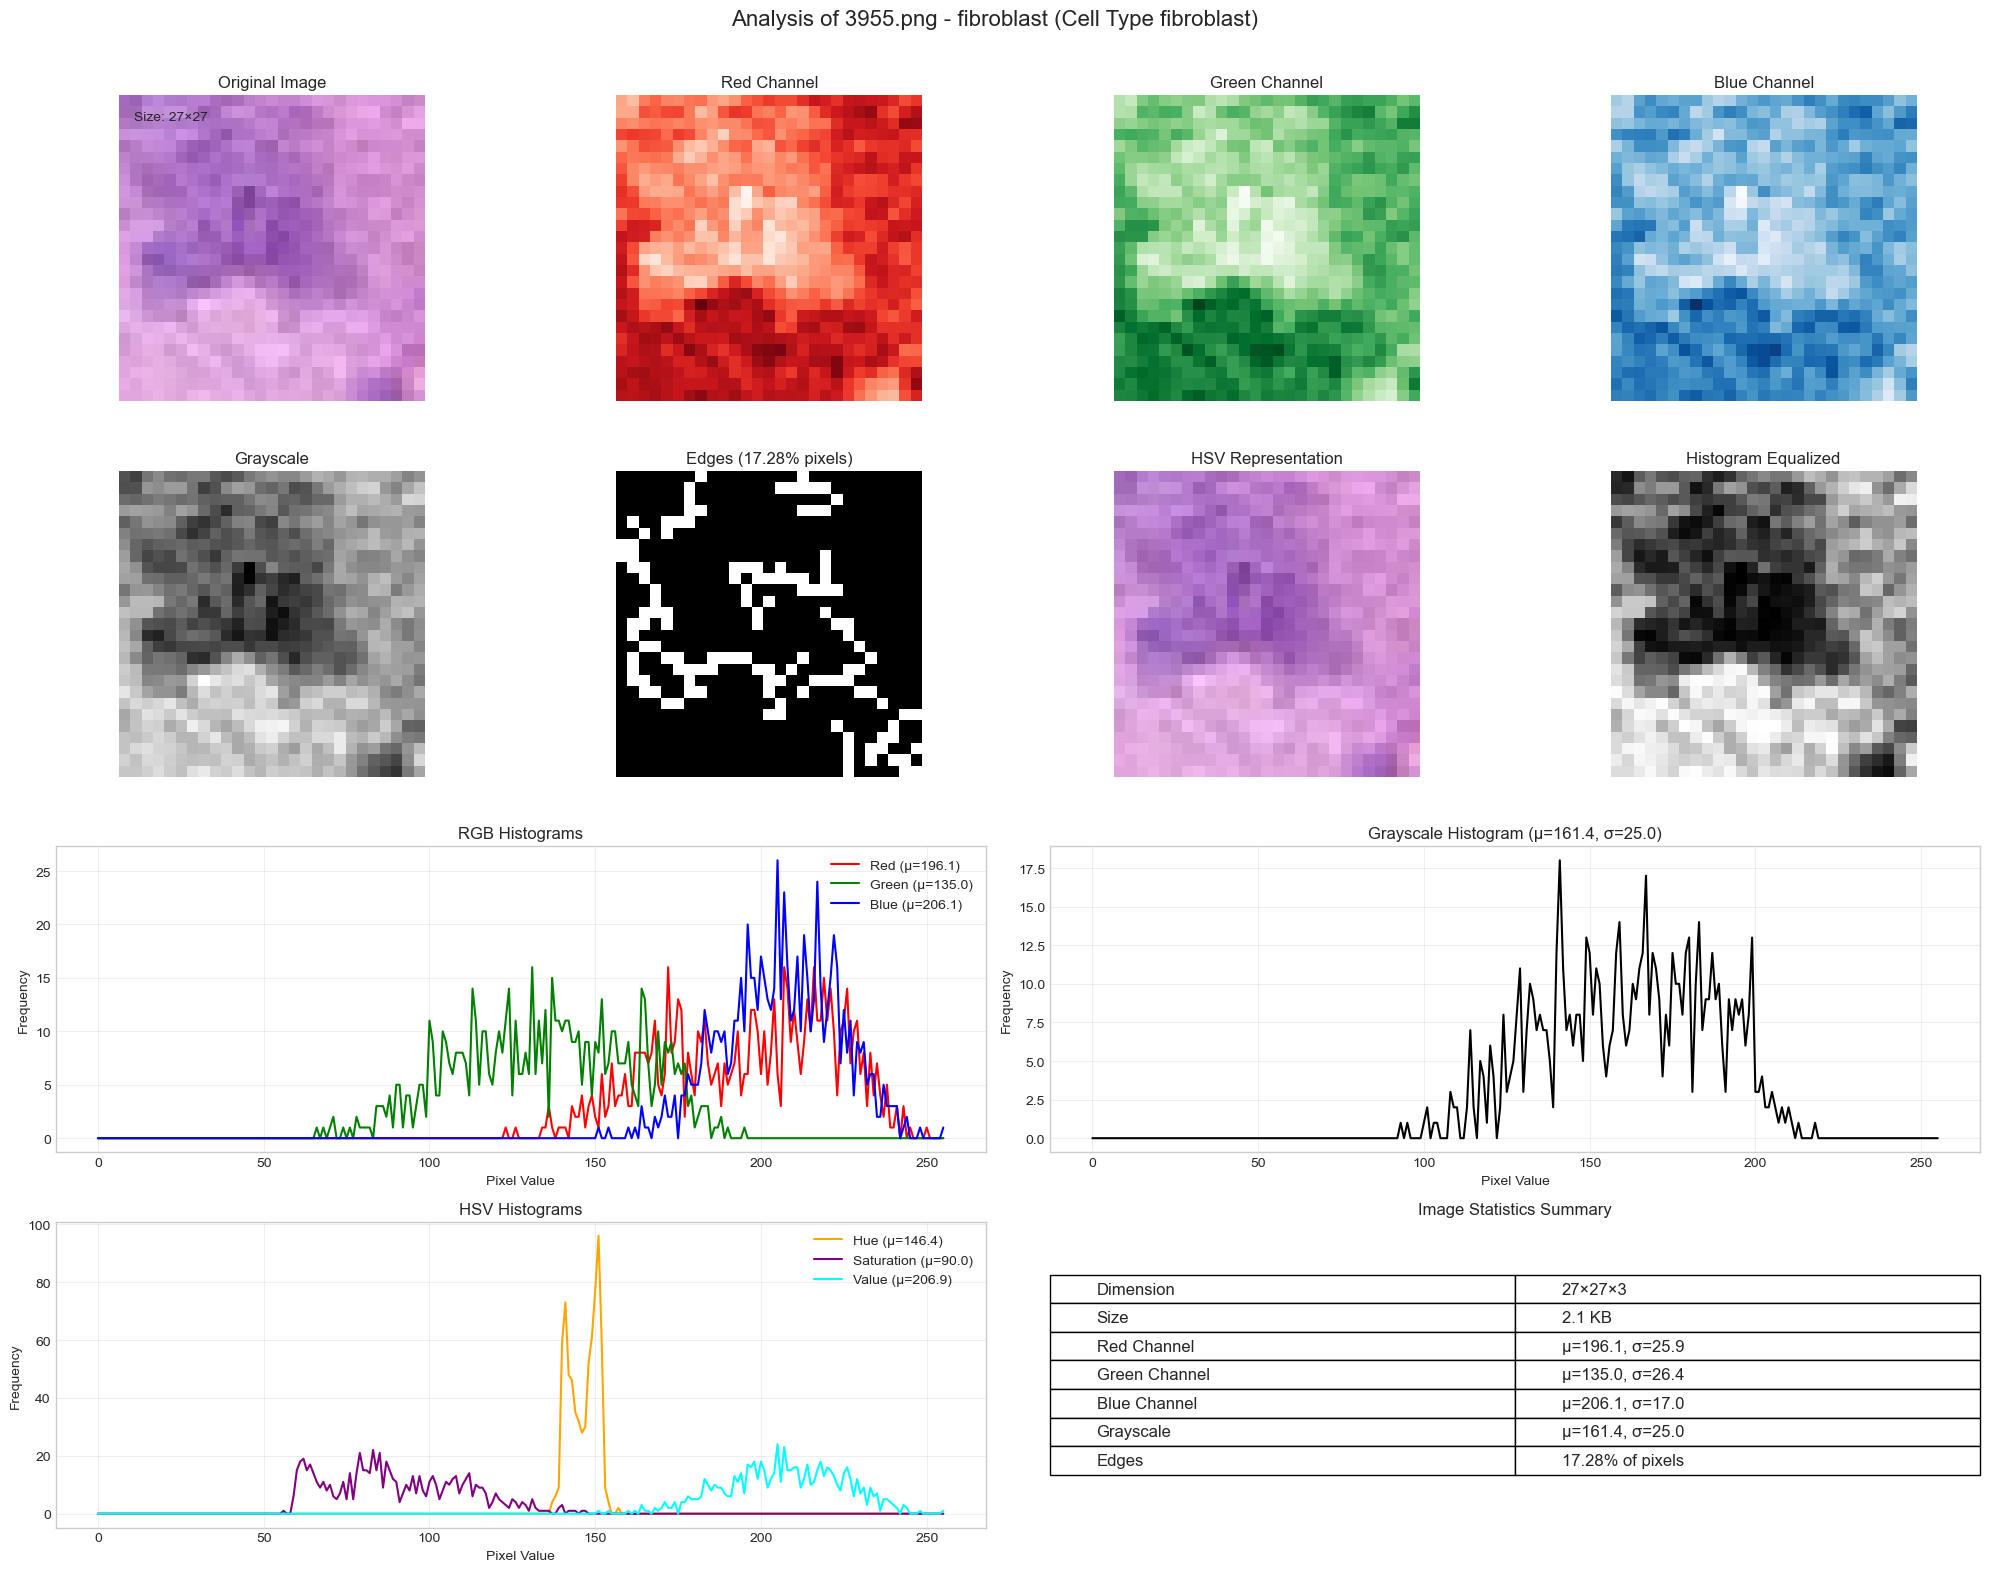

In [19]:
image_dir = "./data/patch_images"
analyze_images_by_cell_type(data, image_dir, 'fibroblast')

In [20]:
# TODO: Add the analysis here

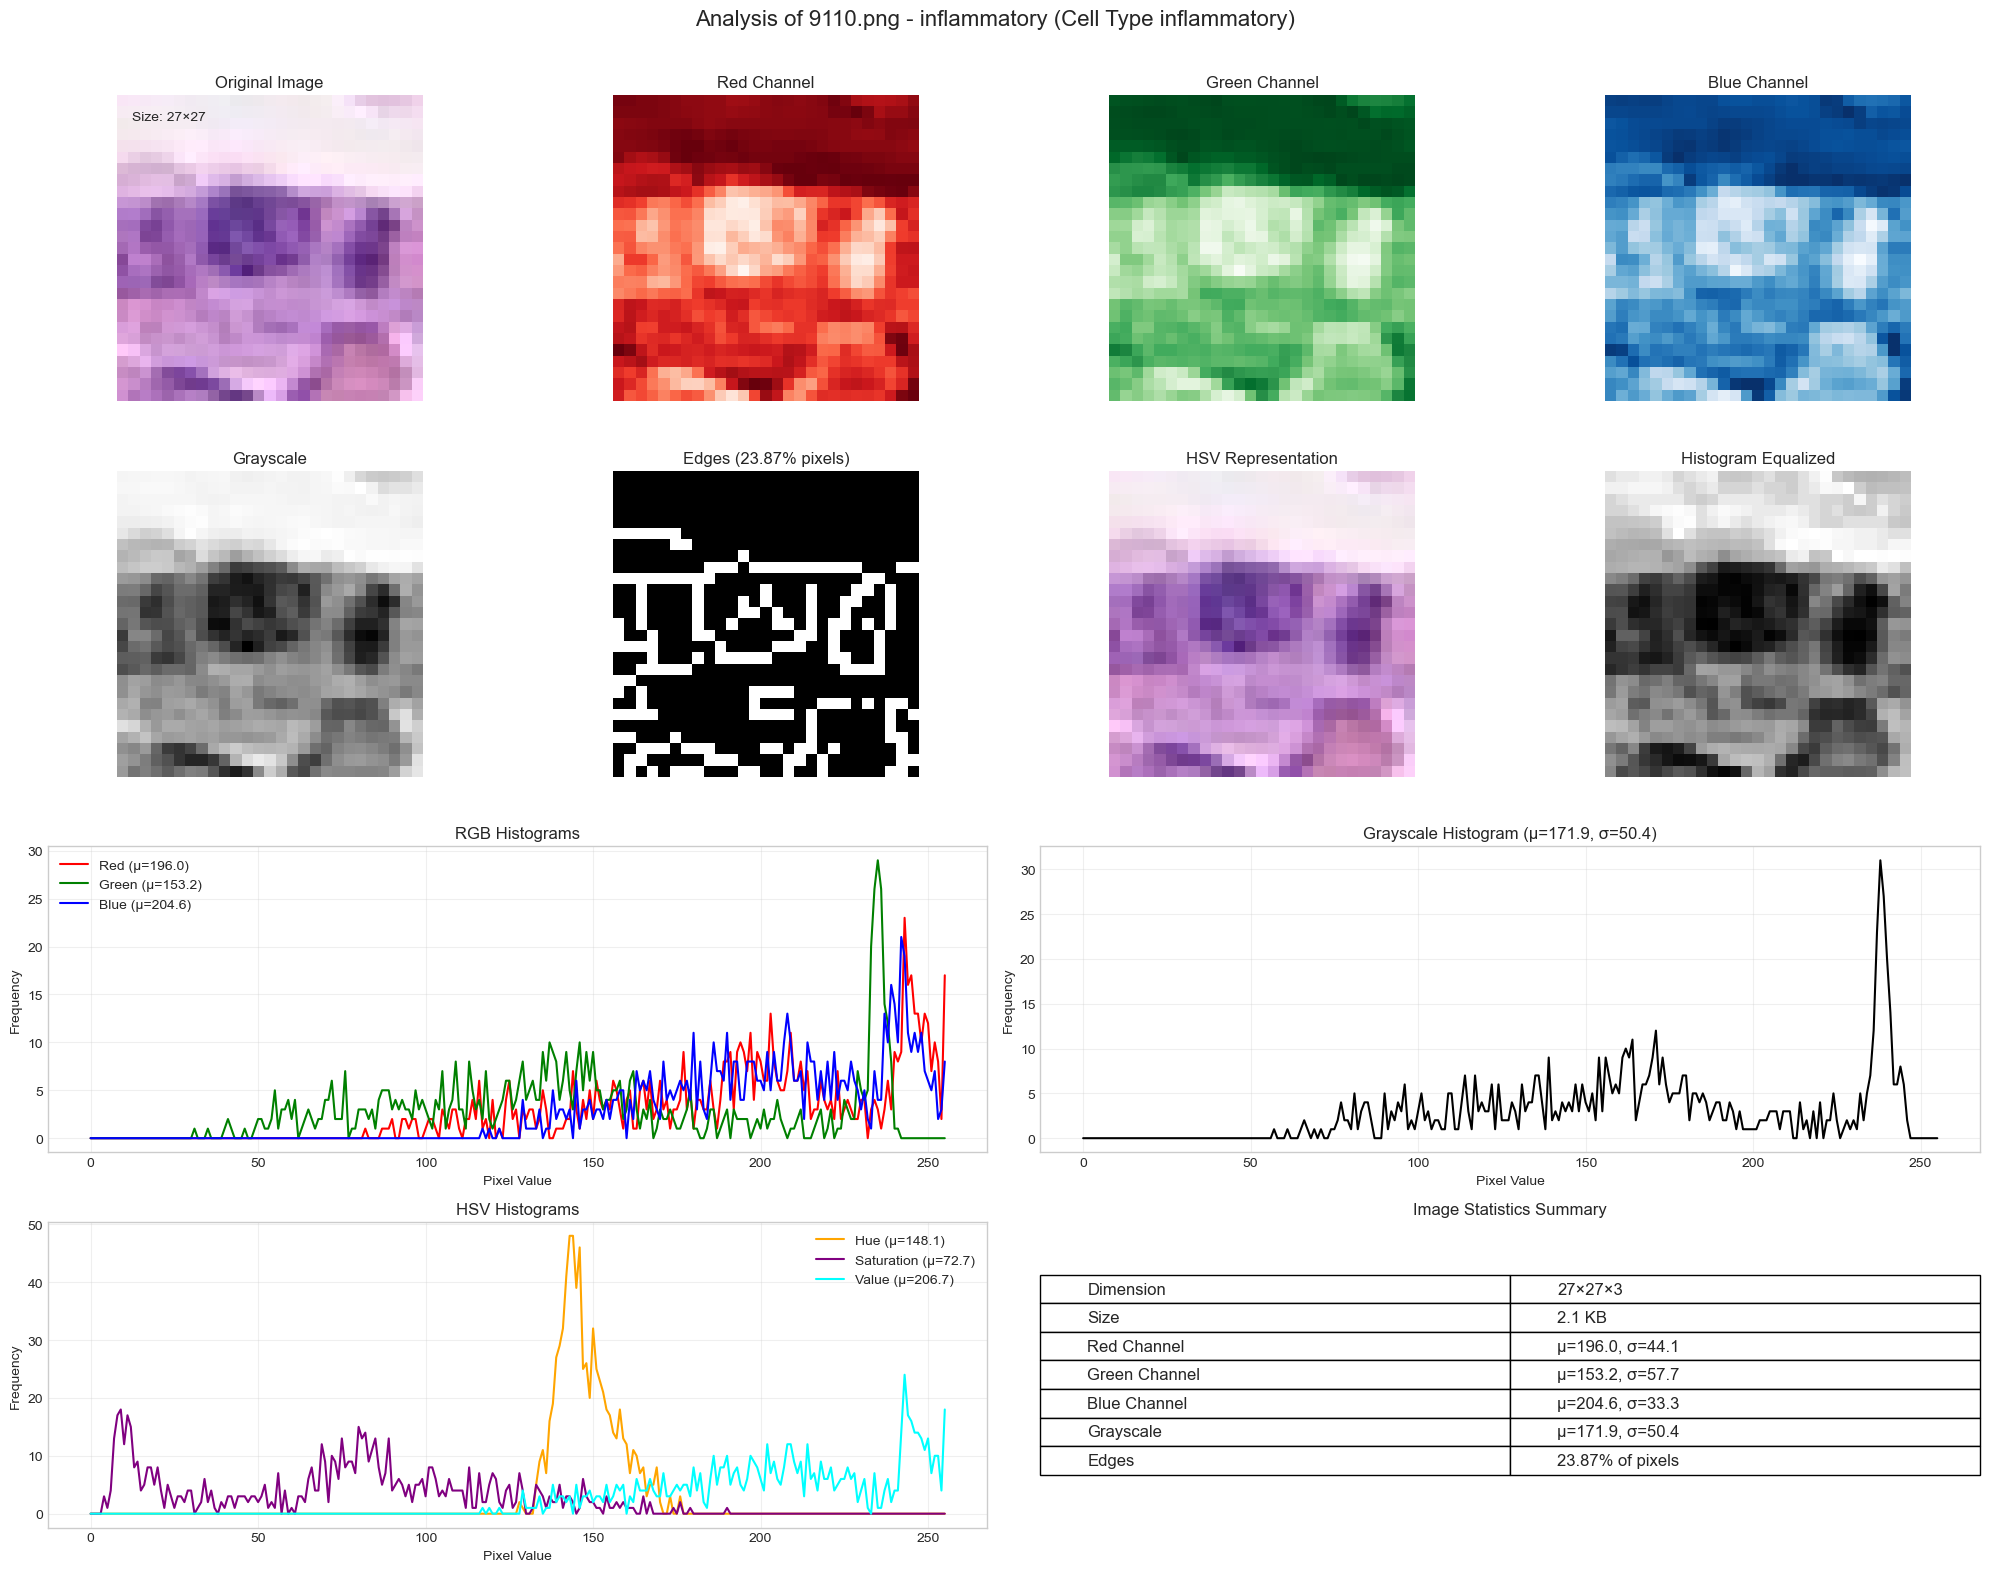

In [21]:
analyze_images_by_cell_type(data, image_dir, 'inflammatory')

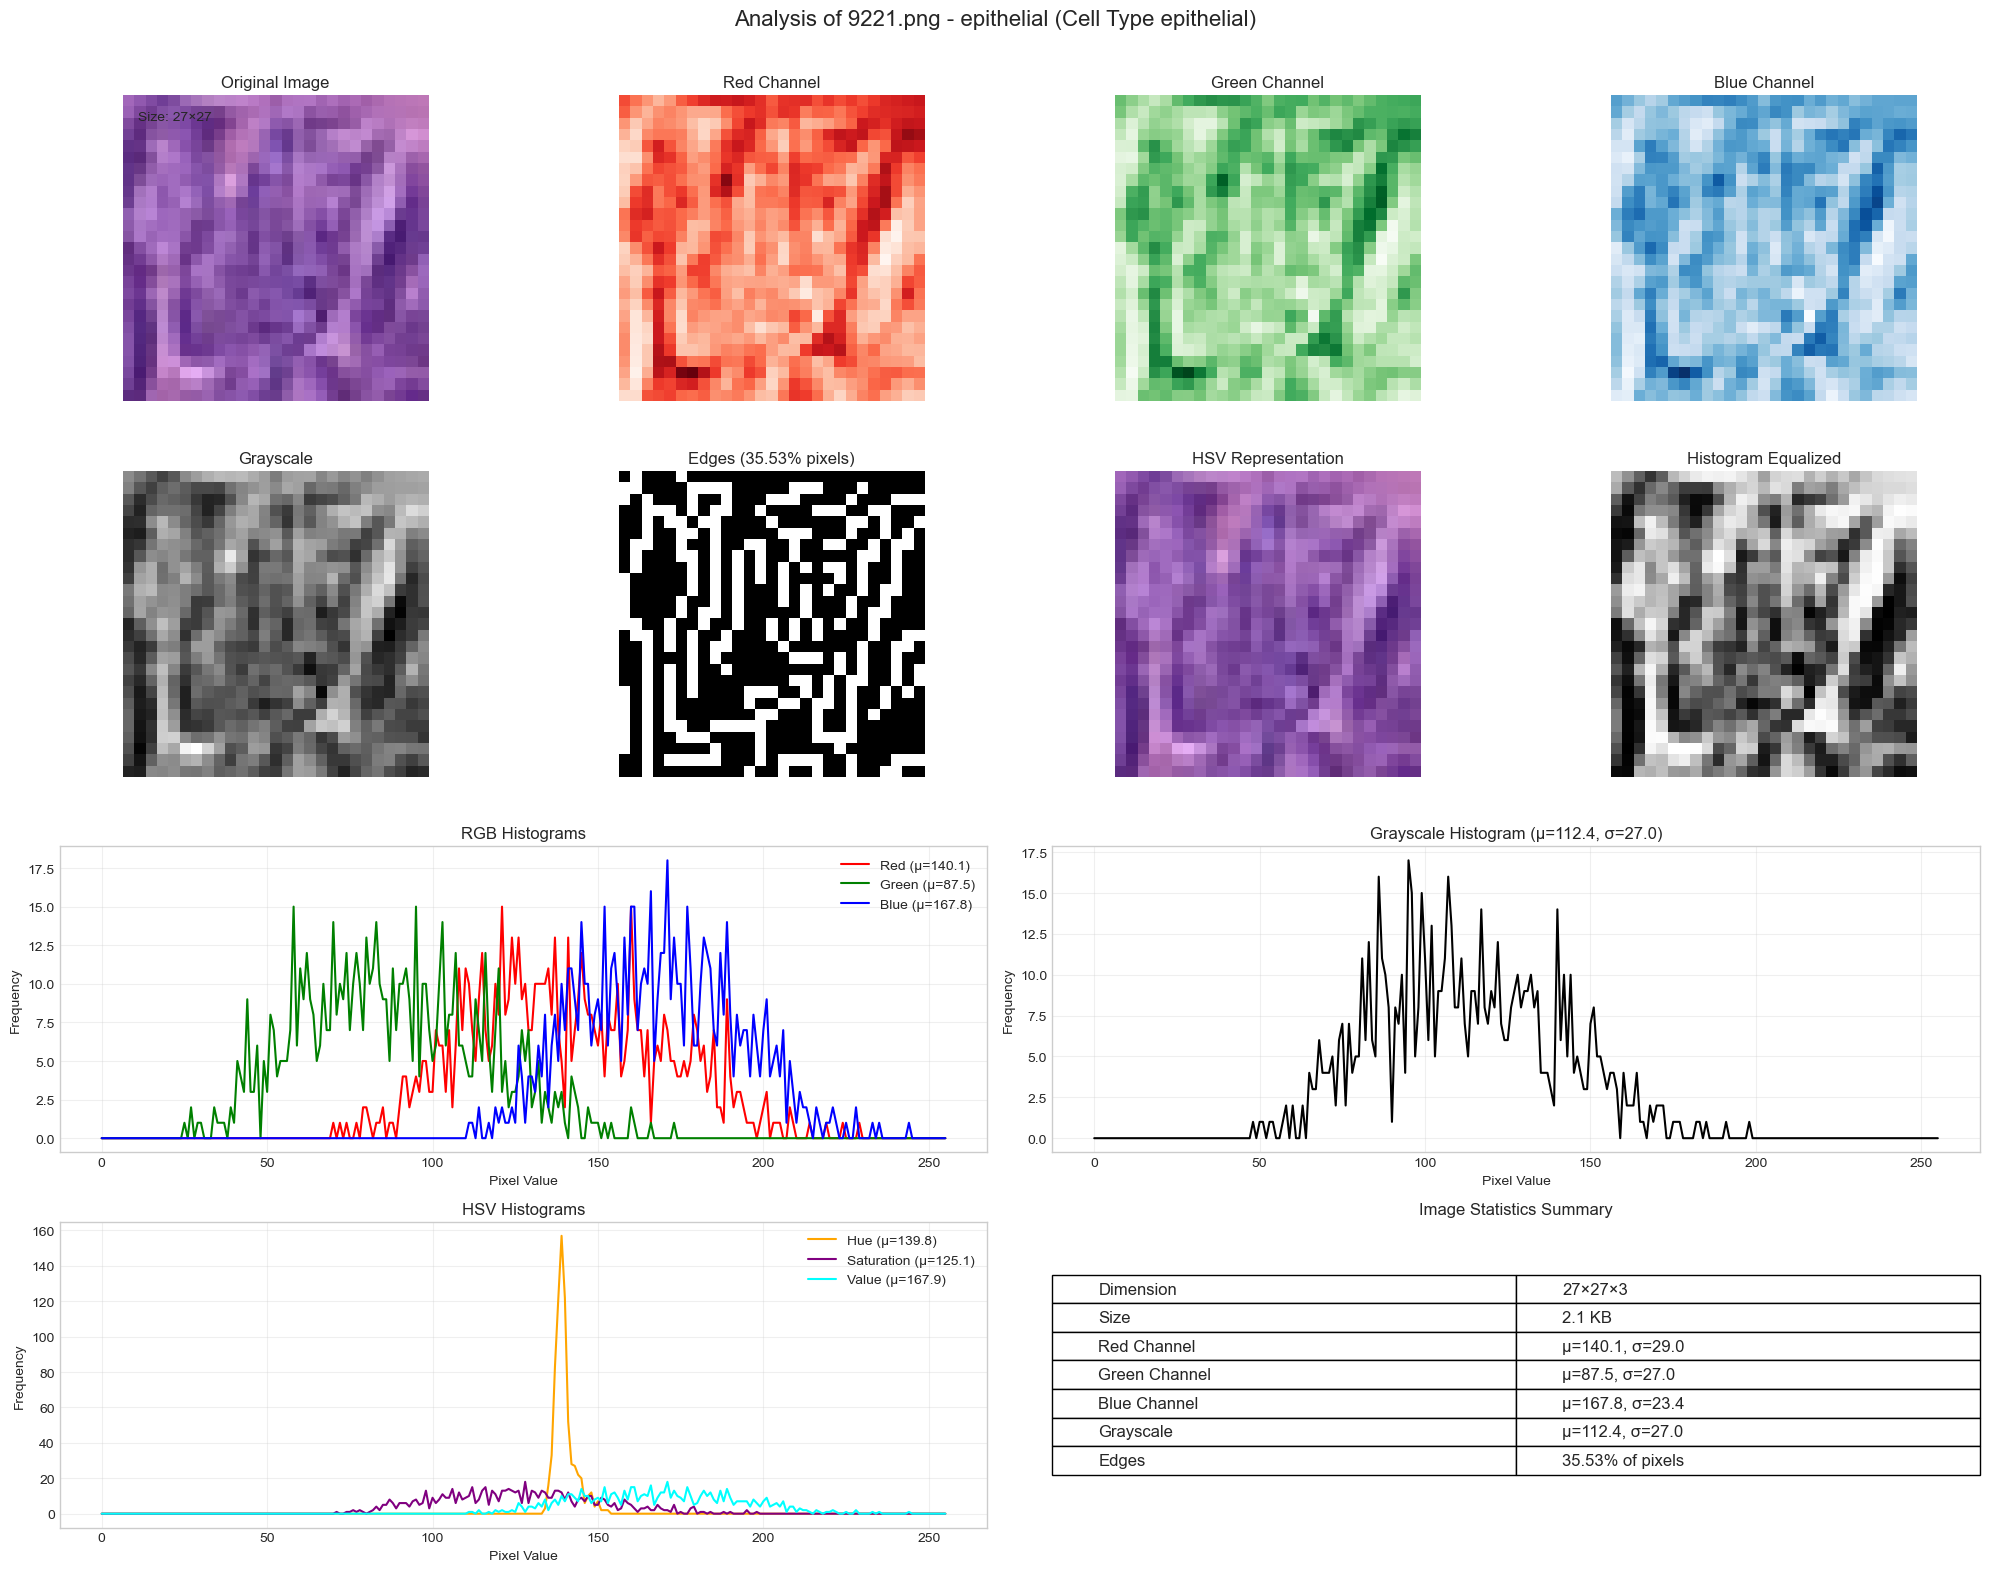

In [22]:
analyze_images_by_cell_type(data, image_dir, 'epithelial')

### EDA Summary

In summary, the given dataset has **9896** and **6** columns, in which two ID columns and the 3 categorical variables, which cellTypeName and cellType columns describe the cell type and isCancerous column tell if the patient has the cancer or not. Also, there is no additional features (i.e. text, integer), which indicate that for this task, both cellType and isCanerous will be predicted via the given images in patches_images folder. 
Besides that, the given dataset provides noticable information including:

- The cancer cell type has been encoded with numeric value
- The data is **imbalanced** data

As the data is imbalanced, data augumentation will be used. Since the cell type is, it is feasible to rotate or flipping the images without affecting the orientation.